In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
model_version = 'v11.0'

In [5]:
with open('../data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"../data/processed/spectrometry_photometry.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Activation('relu', name='Act_64')(x)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Activation('relu', name='Act_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Activation('relu', name='Act_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Activation('relu', name='Act_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.Huber(), 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 39)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2560      
                                                                 
 Act_64 (Activation)         (None, 64)                0         
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Act_128 (Activation)        (None, 128)               0         
                                                                 
 Dropout_128 (Dropout)       (None, 128)          

In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.5,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2443/2443 [==============================] - 21s 8ms/step - loss: 0.6989 - mae: 0.8448 - mse: 3.8512 - mape: 8.0327 - val_loss: 0.1399 - val_mae: 0.2053 - val_mse: 0.0725 - val_mape: 1.9503
Epoch 2/200
2443/2443 [==============================] - 19s 8ms/step - loss: 0.3059 - mae: 0.5780 - mse: 0.5300 - mape: 5.4782 - val_loss: 0.0514 - val_mae: 0.1658 - val_mse: 0.0465 - val_mape: 1.5845
Epoch 3/200
2443/2443 [==============================] - 19s 8ms/step - loss: 0.2324 - mae: 0.5324 - mse: 0.4522 - mape: 5.0472 - val_loss: 0.0291 - val_mae: 0.1245 - val_mse: 0.0353 - val_mape: 1.2044
Epoch 4/200
2443/2443 [==============================] - 18s 7ms/step - loss: 0.1924 - mae: 0.4878 - mse: 0.3797 - mape: 4.6270 - val_loss: 0.0339 - val_mae: 0.1667 - val_mse: 0.0526 - val_mape: 1.6052
Epoch 5/200
2443/2443 [==============================] - 18s 7ms/step - loss: 0.1678 - mae: 0.4525 - mse: 0.3297 - mape: 4.2992 - val_loss: 0.0281 - val_mae: 0.1323 - val_mse: 0.0412 - val_map

In [11]:
model.save(f'../models/{model_version}/photo_no_transfer_model.h5')

In [12]:
save_history(history, model_version, 'history_photo_no_transfer')

In [13]:
y_pred = model.predict(X_test_scaled)

2094/2094 [==============================] - 3s 1ms/step


In [14]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0865
Root Mean Squared Error (RMSE): 0.1849
R² Score: 0.9209


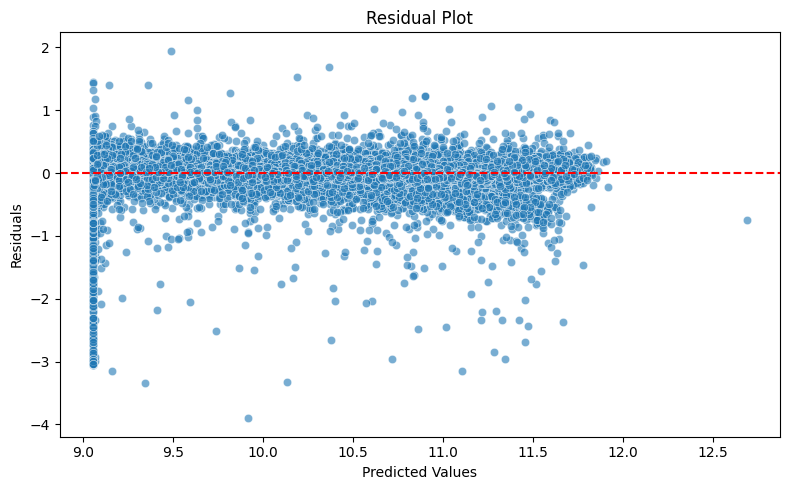

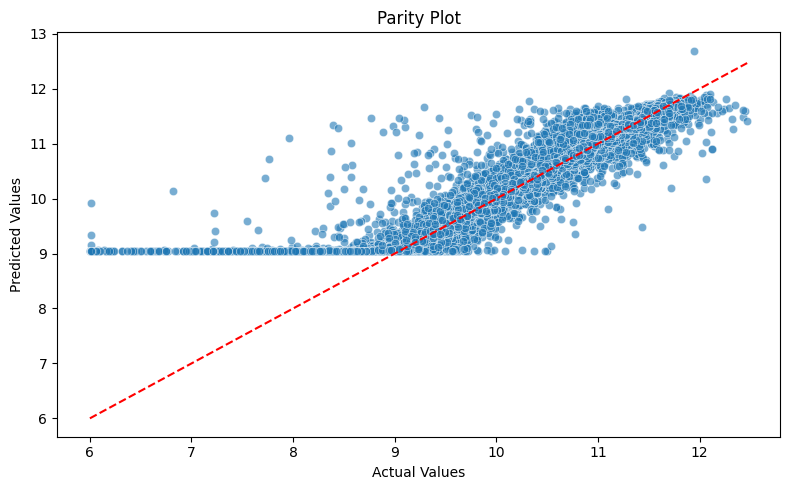

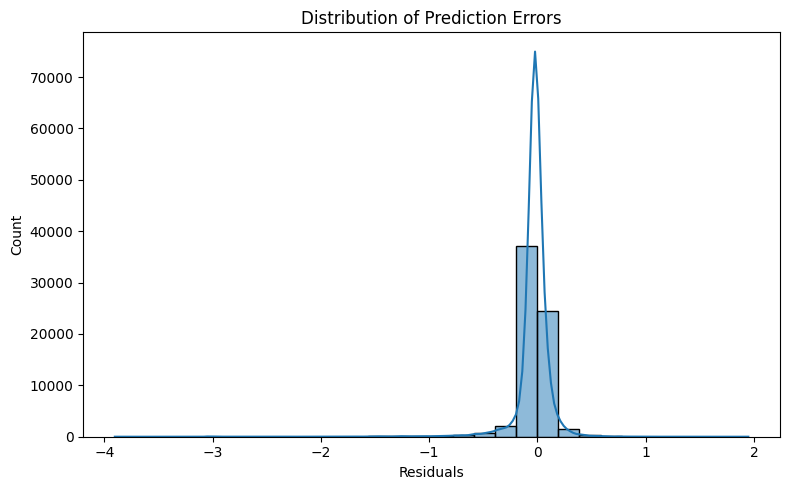

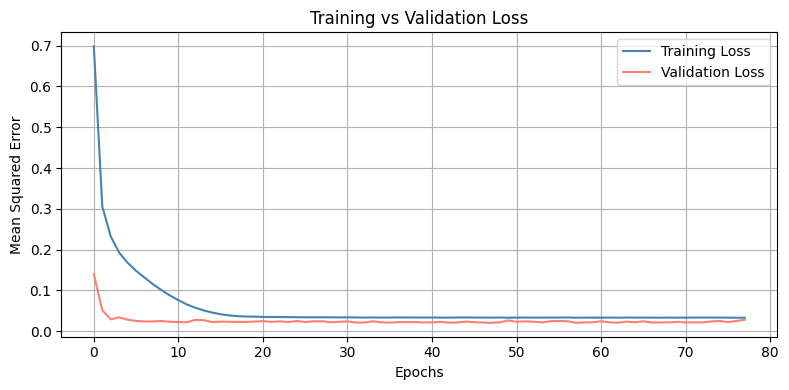

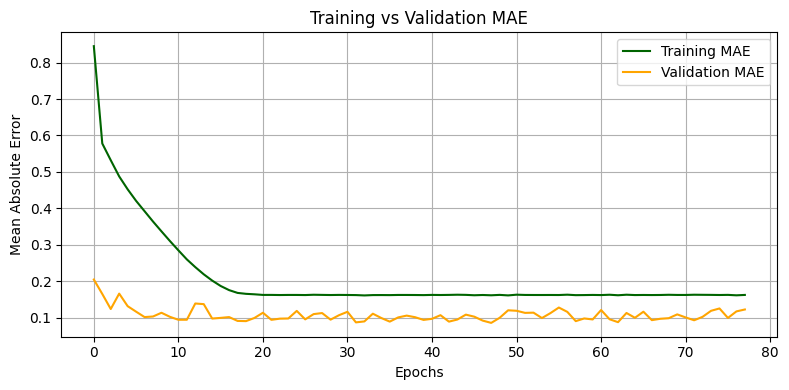

In [15]:
plot_visualizations(history, y_test, y_pred)

In [16]:
df_unseen = pd.read_csv(f"../data/processed/unseen_data.csv")

X_unseen = df_unseen[photo_cols + generic_cols]
y_unseen = df_unseen[target_col]

In [17]:
X_unseen_scaled = scaler.transform(X_unseen)

In [18]:
y_pred_unseen = model.predict(X_unseen_scaled)

6980/6980 [==============================] - 9s 1ms/step


In [19]:
plot_metrics(y_unseen, y_pred_unseen)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0863
Root Mean Squared Error (RMSE): 0.1813
R² Score: 0.9231


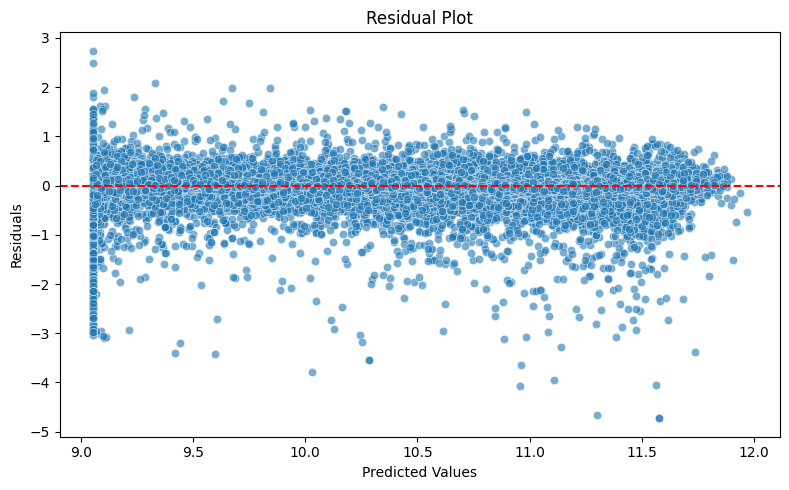

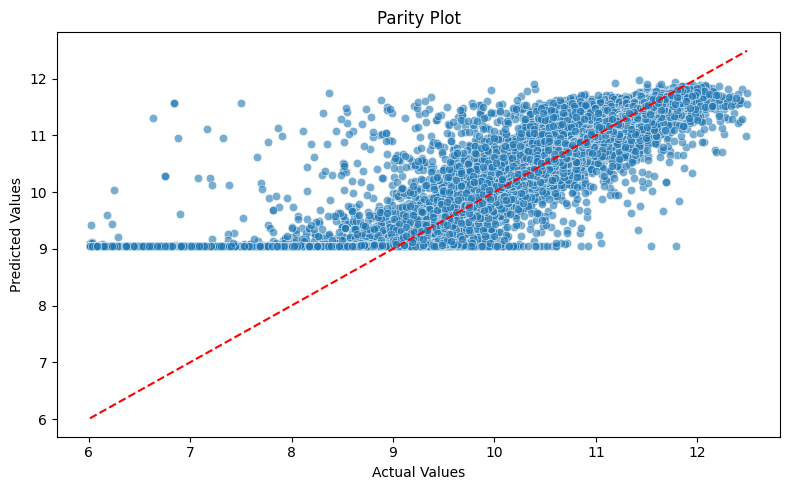

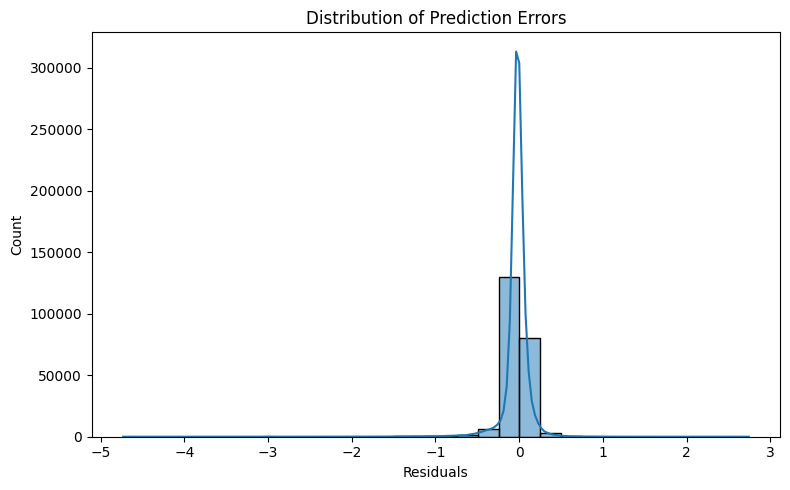

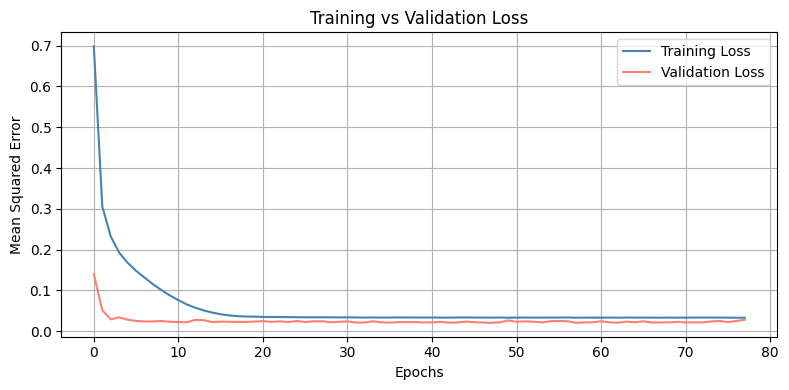

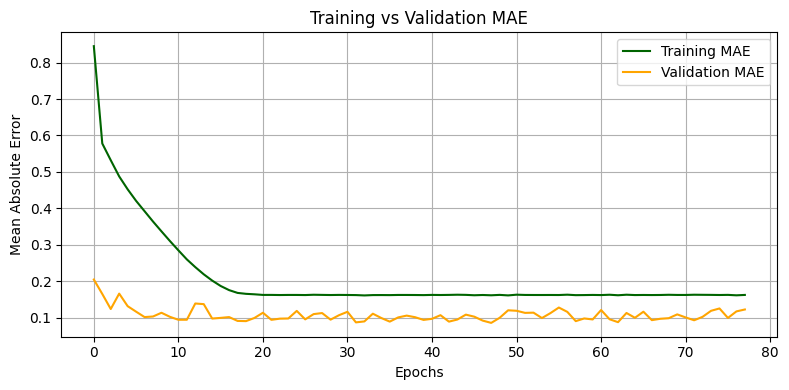

In [20]:
plot_visualizations(history, y_unseen, y_pred_unseen)